<a href="https://colab.research.google.com/github/myprogrammerpersonality/BlackBoxOptimizer/blob/master/BBO_v3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> version 3: </h1>
+ Log Scale Random Number Throug Manual Input<br>           
+ Multiple Stocks<br>
+ Echo Machine File Output<br>
+ Merge Automatic and Manual Functions

## User Inputs

Main notebook that includes data processing and bayesian optimization function

In [16]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
import time
from sklearn.model_selection import RandomizedSearchCV
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from collections.abc import Iterable

pd.options.mode.chained_assignment = None  # default='warn'
!wget https://raw.githubusercontent.com/myprogrammerpersonality/BlackBoxOptimizer/master/functions_final.py
from functions_final import *

--2020-08-29 11:30:10--  https://raw.githubusercontent.com/myprogrammerpersonality/BlackBoxOptimizer/master/functions_final.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20233 (20K) [text/plain]
Saving to: ‘functions_final.py.1’

functions_final.py. 100%[===================>]  19.76K  --.-KB/s    in 0.004s  

2020-08-29 11:30:10 (5.25 MB/s) - ‘functions_final.py.1’ saved [20233/20233]



In [17]:
# General Parameters:
m = 20      # number_of_combination_each_round
minimum_drop_size_nanoliter = 100
final_reaction_volume_nanoliter = 20000
maximum_volume_of_model_output = 13200 # (e.g. volume except lysate)
fixed_parts = {'Lysate':0.33, 'Saline':0.01} # 0.33 means 33% of total volume will be Lysate, 1% saline solution
days_total = 10 # how many days you want to continue # set it at your max prediction

# Model Parameters:
RandomCV = True
n_iter = 200
ensemble_len = 20 
exploration = {2: 1.41, 3: 1.41,
               4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0,
               8: 0.5, 9: 0.5, 9: 0.5, 10: 0.5}
days_range = [m for i in range(days_total)]

In [18]:
# Part 1: choose grid for our metabolite conc and define stock concentration

# it is important to define all value for function to be able to get conc that is appropriate to your minimum drop size
# each metabolite min, max and stock must be in same units

# concentrations_limits :
# format for one alternative : (min, max, stock)
# format for more than one alternatives : (min, max, stock, (alternative 1, alternative 2, alternative 3))
# *** metabolite name must not includes "_" ***

concentrations_limits = {
 'TF':{'Conc_Min':0.1, 'Conc_Max':1000.0, 'Conc_Values':None, 'Conc_Stock':1000.0, 'Alternatives':['A1','B2','C2']},
 'K-Glutamate':{'Conc_Min':30, 'Conc_Max':150, 'Conc_Values':None, 'Conc_Stock':3000.0, 'Alternatives':None},
 'MG-Glutamate':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[10.0,20.0,30.0,50.0,100.0], 'Conc_Stock':1000.0, 'Alternatives':None},
 'Restriction Enzyme':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[10.0,20.0,30.0,50.0,100.0], 'Conc_Stock':1000.0, 'Alternatives':['EcoRI', 'EcoRII']},
 'Restriction Enzyme-2':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[10.0,20.0,30.0,50.0,100.0], 'Conc_Stock':1000.0, 'Alternatives':['BamHI']},
 'Multiple':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[1.0,3.0,5.0,10.0,30.0,50.0,100.0], 'Conc_Stock':[100.0,1000.0], 'Alternatives':None},
 'Multiple-2':{'Conc_Min':None, 'Conc_Max':None, 'Conc_Values':[1.0,3.0,5.0,10.0,30.0,50.0,100.0], 'Conc_Stock':[100.0,1000.0], 'Alternatives':['Type1','Type2']},
 'DNA':{'Conc_Min':20.0, 'Conc_Max':20.0, 'Conc_Values':None, 'Conc_Stock':1000.0, 'Alternatives':None}}

In [19]:
def find_stock(conc_values, conc_stocks, this_value):
    num = len(conc_stocks)
    avg = len(conc_values) / float(num)
    out = []
    last = 0.0

    while last < len(conc_values):
        out.append(conc_values[int(last):int(last + avg)])
        last += avg

    for i, value in enumerate(out):
        if this_value in value:
            return i, out

# define random combination generator function_v3.0
def random_combination_generator(concentrations_limits, number_of_combination=100, reaction_vol_nl=10000,
                                 max_nl=None, drop_size_nl=100, check_repeat=True, rounded=2, verbose=0, make_csv=False, return_df=False):
    #  drop size safe
    #  water <0 safe
    #  concentrations_limits is a Dict in this format:
    #  {'name of metabolite': {'Conc_Min': #, 'Conc_Max': #, 'Conc_Values': #, 'Conc_Stock': #, 'Alternatives': #}}

    # generating random combinations
    combinations = []
    data_point = 0
    while data_point < number_of_combination:
        input_data = []
        input_vol = []
        # verbosity
        if (data_point % 10000 == 0) and verbose:
            print(data_point)

        # generation of random input
        for key, value in concentrations_limits.items():
            # Manual Concentration Value Generation
            if value['Conc_Values']:
                # With Alternatives
                if value['Alternatives']:
                    num_alternative = len(value['Alternatives'])
                    choice_alternative = np.random.randint(0, num_alternative)
                    choice_list = [0 for i in range(num_alternative)]
                    choice_list[choice_alternative] = 1

                    choice_conc = np.random.choice(value['Conc_Values'])
                    input_data.append(choice_conc)
                    input_data += choice_list
                    if isinstance(value['Conc_Stock'], Iterable):
                        choice_stock, _ = find_stock(value['Conc_Values'], value['Conc_Stock'], choice_conc)
                        input_vol.append(choice_conc/value['Conc_Stock'][choice_stock]*reaction_vol_nl)
                    else:
                        input_vol.append(choice_conc/value['Conc_Stock']*reaction_vol_nl)

                # Without Alternatives
                else:
                    choice_conc = np.random.choice(value['Conc_Values'])
                    input_data.append(choice_conc)
                    if isinstance(value['Conc_Stock'], Iterable):
                        choice_stock, _ = find_stock(value['Conc_Values'], value['Conc_Stock'], choice_conc)
                        input_vol.append(choice_conc/value['Conc_Stock'][choice_stock]*reaction_vol_nl)
                    else:
                        input_vol.append(choice_conc/value['Conc_Stock']*reaction_vol_nl)

            # Auto Concentration Value Generation
            else:
                # With Alternatives
                if value['Alternatives']:
                    num_alternative = len(value['Alternatives'])
                    choice_alternative = np.random.randint(0, num_alternative)
                    choice_list = [0 for i in range(num_alternative)]
                    choice_list[choice_alternative] = 1

                    drop_num = np.random.randint(round(value['Conc_Min'] * (reaction_vol_nl / drop_size_nl) / value['Conc_Stock']),
                                                 round(value['Conc_Max'] * (reaction_vol_nl / drop_size_nl) / value['Conc_Stock']) + 1)

                    recalculated_conc = drop_num * value['Conc_Stock'] * drop_size_nl / reaction_vol_nl
                    input_data.append(recalculated_conc)
                    input_data += choice_list
                    input_vol.append(recalculated_conc/value['Conc_Stock']*reaction_vol_nl)

                # Without Alternatives
                else:
                    drop_num = np.random.randint(round(value['Conc_Min'] * (reaction_vol_nl / drop_size_nl) / value['Conc_Stock']),
                                                 round(value['Conc_Max'] * (reaction_vol_nl / drop_size_nl) / value['Conc_Stock']) + 1)

                    recalculated_conc = drop_num * value['Conc_Stock'] * drop_size_nl / reaction_vol_nl
                    input_data.append(recalculated_conc)
                    input_vol.append(recalculated_conc/value['Conc_Stock']*reaction_vol_nl)
        
        # Checks
        if check_repetitive and max_nl:
            if input_data not in combinations and sum(input_vol)<= max_nl:
                combinations.append(input_data)
                data_point += 1
        elif check_repetitive and not max_nl:
            if input_data not in combinations:
                combinations.append(input_data)
                data_point += 1
        elif not check_repetitive and max_nl:
            if sum(input_vol)<= max_nl:
                combinations.append(input_data)
                data_point += 1
        else:
            combinations.append(input_data)
            data_point += 1

    # make column name:
    columns_name = []
    for key, value in concentrations_limits.items():
        if not value['Alternatives']:
            columns_name.append(key)
        else:
            columns_name.append(key)
            alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
            columns_name += alternative_name

    # making csv file
    if make_csv:
        data = pd.DataFrame(np.array(combinations), columns=columns_name)
        data.to_csv('Random_Combination_1.csv', index=False)

    # making dataframe
    if return_df:
        data = pd.DataFrame(np.array(combinations), columns=columns_name)
        return data

    return np.array(combinations)


conc_test = random_combination_generator(concentrations_limits, number_of_combination=20, reaction_vol_nl=20000,
                                         max_nl=13200, drop_size_nl=100, check_repeat=True, return_df=True)
conc_test

,TF,TF_A1,TF_B2,TF_C2,K-Glutamate,MG-Glutamate,Restriction Enzyme,Restriction Enzyme_EcoRI,Restriction Enzyme_EcoRII,Restriction Enzyme-2,Restriction Enzyme-2_BamHI,Multiple,Multiple-2,Multiple-2_Type1,Multiple-2_Type2,DNA
0,330.0,0.0,0.0,1.0,150.0,50.0,20.0,0.0,1.0,100.0,1.0,5.0,10.0,0.0,1.0,20.0
1,275.0,0.0,0.0,1.0,135.0,10.0,30.0,0.0,1.0,10.0,1.0,3.0,1.0,0.0,1.0,20.0
2,175.0,0.0,0.0,1.0,105.0,20.0,20.0,1.0,0.0,100.0,1.0,10.0,5.0,0.0,1.0,20.0
3,130.0,0.0,1.0,0.0,45.0,10.0,10.0,1.0,0.0,30.0,1.0,30.0,10.0,0.0,1.0,20.0
4,355.0,0.0,0.0,1.0,150.0,30.0,50.0,0.0,1.0,10.0,1.0,10.0,50.0,1.0,0.0,20.0
5,190.0,0.0,1.0,0.0,75.0,30.0,50.0,0.0,1.0,50.0,1.0,3.0,50.0,1.0,0.0,20.0
6,310.0,1.0,0.0,0.0,45.0,100.0,10.0,0.0,1.0,30.0,1.0,5.0,100.0,0.0,1.0,20.0
7,185.0,0.0,0.0,1.0,150.0,50.0,20.0,0.0,1.0,30.0,1.0,1.0,10.0,0.0,1.0,20.0
8,10.0,0.0,0.0,1.0,135.0,30.0,50.0,0.0,1.0,10.0,1.0,50.0,5.0,0.0,1.0,20.0
9,170.0,0.0,0.0,1.0,90.0,30.0,30.0,0.0,1.0,10.0,1.0,30.0,1.0,1.0,0.0,20.0


In [20]:
# transform concentration DataFrame to volume (nanolitre) DataFrame
def concentration_to_volume(concentrations, concentrations_limits, reaction_mixture_vol_nl=10000,
                            fixed_parts={'Lysate': 0.33, 'Saline': 0.1}, round_deg=3):
    # concentrations is a Pandas DataFrame in this format:
    #   {'name of metabolite': concentration}
    # concentrations_limits is a Dict in this format:
    # concentrations_limits (min, max, stock)
    # caution: concentration unit and metabolite name in concentrations and concentrations_limits must be the same

    # make a copy of original dataframe to avoid further change than can affect that
    data = concentrations.copy(deep=True)
    data_all = data.copy(deep=True)
    data = data[[i for i in data.columns if '_' not in i]]
    data *= reaction_mixture_vol_nl

    for metabolite_name, value in concentrations_limits.items():
        if isinstance(value['Conc_Stock'], Iterable):
            print()
            data[metabolite_name] = [round(data[metabolite_name][i] / value['Conc_Stock'][find_stock(value['Conc_Values'], value['Conc_Stock'], data_all[metabolite_name][i])[0]], round_deg) for i in range(len(data[metabolite_name]))]
        else:
            data[metabolite_name] /= value['Conc_Stock']

    # add fix parts
    if fixed_parts:
        for key, value in fixed_parts.items():
            data[key] = reaction_mixture_vol_nl * value

    # add water to reach the reaction_mixture_vol_nl
    data['water'] = reaction_mixture_vol_nl - data.sum(axis=1)

    # for low stock concentration that is not possible to make, raise an error
    # stock conc should set in a way that dont raise this error to avoid further debugging
    if not all(data['water'] > 0): raise Exception("Oops, too concentrated combination!")

    # add alternative
    # make columns name list:
    columns_name = []
    Type_dic = {}
    Stock_dic = {}
    for key, value in concentrations_limits.items():
        if value['Alternatives']:
            columns_name.append(key)
            columns_name.append('{}_Type'.format(key))
            Type_dic[key] = []
        else:
            columns_name.append(key)
        if isinstance(value['Conc_Stock'], Iterable):
            columns_name.append('{}_Stock_Type'.format(key))
            Stock_dic[key] = []

    # Alternatives
    for key in Type_dic.keys():
        data_type = data_all[[i for i in data_all.columns if '{}_'.format(key) in i]]
        for i in data_type.values:
            Type_dic[key].append(concentrations_limits[key]['Alternatives'][np.where(i == 1.0)[0][0]])

    Type_list = list(Type_dic.keys())
    for key in Type_list:
        Type_dic['{}_Type'.format(key)] = Type_dic.pop(key)

    # Stock
    for key in Stock_dic.keys():
        Stock_dic[key] = [concentrations_limits[key]['Conc_Stock'][find_stock(concentrations_limits[key]['Conc_Values'], concentrations_limits[key]['Conc_Stock'], i)[0]] for i in data_all[key]]
         
    Stock_list = list(Stock_dic.keys())
    for key in Stock_list:
        Stock_dic['{}_Stock_Type'.format(key)] = Stock_dic.pop(key)

    data_final = pd.concat([data, pd.DataFrame(Type_dic), pd.DataFrame(Stock_dic)], axis=1)
    return data_final[columns_name + list(fixed_parts.keys()) + ['water']]


concentration_to_volume(conc_test, concentrations_limits, reaction_mixture_vol_nl=20000,
                        fixed_parts={'Lysate': 0.32, 'Saline': 0.01}, round_deg=3)

,TF,TF_Type,K-Glutamate,MG-Glutamate,Restriction Enzyme,Restriction Enzyme_Type,Restriction Enzyme-2,Restriction Enzyme-2_Type,Multiple,Multiple_Stock_Type,Multiple-2,Multiple-2_Type,Multiple-2_Stock_Type,DNA,Lysate,Saline,water
0,6600.0,C2,1000.0,1000.0,400.0,EcoRII,2000.0,BamHI,1000.0,100.0,200.0,Type2,1000.0,400.0,6400.0,200.0,800.0
1,5500.0,C2,900.0,200.0,600.0,EcoRII,200.0,BamHI,600.0,100.0,200.0,Type2,100.0,400.0,6400.0,200.0,4800.0
2,3500.0,C2,700.0,400.0,400.0,EcoRI,2000.0,BamHI,200.0,1000.0,1000.0,Type2,100.0,400.0,6400.0,200.0,4800.0
3,2600.0,B2,300.0,200.0,200.0,EcoRI,600.0,BamHI,600.0,1000.0,200.0,Type2,1000.0,400.0,6400.0,200.0,8300.0
4,7100.0,C2,1000.0,600.0,1000.0,EcoRII,200.0,BamHI,200.0,1000.0,1000.0,Type1,1000.0,400.0,6400.0,200.0,1900.0
5,3800.0,B2,500.0,600.0,1000.0,EcoRII,1000.0,BamHI,600.0,100.0,1000.0,Type1,1000.0,400.0,6400.0,200.0,4500.0
6,6200.0,A1,300.0,2000.0,200.0,EcoRII,600.0,BamHI,1000.0,100.0,2000.0,Type2,1000.0,400.0,6400.0,200.0,700.0
7,3700.0,C2,1000.0,1000.0,400.0,EcoRII,600.0,BamHI,200.0,100.0,200.0,Type2,1000.0,400.0,6400.0,200.0,5900.0
8,200.0,C2,900.0,600.0,1000.0,EcoRII,200.0,BamHI,1000.0,1000.0,1000.0,Type2,100.0,400.0,6400.0,200.0,8100.0
9,3400.0,C2,600.0,600.0,600.0,EcoRII,200.0,BamHI,600.0,1000.0,200.0,Type1,100.0,400.0,6400.0,200.0,6800.0


In [36]:
def bayesian_optimization(regressors_list,
                          data, label,
                          concentrations_limits,
                          final_order,
                          reaction_vol_nl=20000, max_nl=13200, drop_size_nl=100,
                          exploitation=1, exploration=1, test_size=100, pool_size=100000, verbose=0, day=1,
                          days_range=[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]):
    
    # first fit training data on our models
    for regressor in regressors_list:
        regressor.fit(data.values, label.values)

    # make random test data
    df_1 = random_combination_generator(concentrations_limits, number_of_combination=pool_size, reaction_vol_nl=reaction_vol_nl,
                                        max_nl=max_nl, drop_size_nl=drop_size_nl, make_csv=False, return_df=True)


    df_temp = df_1.copy(deep=True)

    # Upper Confidence Bound
    for index, regressor in enumerate(regressors_list):
        df_1['pred_yield_{}'.format(index)] = regressor.predict(df_temp.values)

    df_1['regressors_std'] = df_1[[str(i) for i in df_1.columns if 'pred_yield' in str(i)]].std(axis=1)
    df_1['mean_vote'] = df_1[[str(i) for i in df_1.columns if 'pred_yield' in str(i)]].mean(axis=1)
    df_1['UCB'] = exploitation * df_1['mean_vote'] + exploration * df_1['regressors_std']
    df_1 = df_1.sort_values(['UCB'], ascending=False)

    # check to don`t make repeated combination but it is not likely
    previous = [pd.read_csv('Day_{}/Concentrations_{}.csv'.format(i, i)).iloc[:days_range[i], :] for i in
                range(1, day + 1)]
    df_main = pd.concat(previous)

    chosen_combinations = pd.DataFrame(columns=desired_cols)
    num = 0
    for i in df_1[desired_cols].values:
        temp_combination = pd.DataFrame([i], columns=desired_cols)
        if check_repetitive(temp_combination, df_main):
            num += 1
            chosen_combinations = pd.concat([chosen_combinations, temp_combination]).reset_index(drop=True)
        if num == test_size:
            break

    return chosen_combinations[final_order]

In [47]:
# calc possible conc
def allowed_output(value, reaction_vol_nl=20000, drop_size_nl=100, verbose=0):
    # droplet size along with stock conc and total reaction volume restrict number of possible conc to make
    # here we calc all possible conc

    if value['Conc_Values']:
        if isinstance(value['Conc_Stock'], Iterable):
            drop_nums = [i * reaction_vol_nl / (drop_size_nl * value['Conc_Stock'][find_stock(value['Conc_Values'], value['Conc_Stock'], i)[0]]) for i in value['Conc_Values']]
            calculated_concs = value['Conc_Values']
        else:
            drop_nums = [i * reaction_vol_nl / (drop_size_nl * value['Conc_Stock']) for i in value['Conc_Values']]
            calculated_concs = value['Conc_Values']

    else:
        drop_nums = list(range(int((value['Conc_Min'] * reaction_vol_nl) / (drop_size_nl * value['Conc_Stock'])),
                               int((value['Conc_Max'] * reaction_vol_nl) / (drop_size_nl * value['Conc_Stock'])) + 1))

        calculated_concs = [drop_num * value['Conc_Stock'] * drop_size_nl / reaction_vol_nl for drop_num in drop_nums]

    if verbose:
        print('drops :', drop_nums)
        print('volumes :', [i * drop_size_nl for i in drop_nums])
        print('possible_concentrations :', calculated_concs)
    else:
        return calculated_concs, [i * drop_size_nl for i in drop_nums]

In [48]:
# Check Possible Concentrations
data_lists = {}
num = 0 
for key, value in concentrations_limits.items():
    print('Possible Conc For :',key)
    if not value['Conc_Values']:
        print('Your Min, Max :', "({}, {})".format(value['Conc_Min'], value['Conc_Max']))
    concs, vols = allowed_output(value, reaction_vol_nl = final_reaction_volume_nanoliter, drop_size_nl = minimum_drop_size_nanoliter, verbose=0)
    print(concs)
    data_lists[num] = vols
    num += 1
    print()

percent , pool_size = percentage_possible(data_lists, threshold = maximum_volume_of_model_output)
if pool_size > 10000000: pool_size = 10000000 
print(percent, '% of all possible combination are executable!')

Possible Conc For : TF
Your Min, Max : (0.1, 1000.0)
[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 130.0, 135.0, 140.0, 145.0, 150.0, 155.0, 160.0, 165.0, 170.0, 175.0, 180.0, 185.0, 190.0, 195.0, 200.0, 205.0, 210.0, 215.0, 220.0, 225.0, 230.0, 235.0, 240.0, 245.0, 250.0, 255.0, 260.0, 265.0, 270.0, 275.0, 280.0, 285.0, 290.0, 295.0, 300.0, 305.0, 310.0, 315.0, 320.0, 325.0, 330.0, 335.0, 340.0, 345.0, 350.0, 355.0, 360.0, 365.0, 370.0, 375.0, 380.0, 385.0, 390.0, 395.0, 400.0, 405.0, 410.0, 415.0, 420.0, 425.0, 430.0, 435.0, 440.0, 445.0, 450.0, 455.0, 460.0, 465.0, 470.0, 475.0, 480.0, 485.0, 490.0, 495.0, 500.0, 505.0, 510.0, 515.0, 520.0, 525.0, 530.0, 535.0, 540.0, 545.0, 550.0, 555.0, 560.0, 565.0, 570.0, 575.0, 580.0, 585.0, 590.0, 595.0, 600.0, 605.0, 610.0, 615.0, 620.0, 625.0, 630.0, 635.0, 640.0, 645.0, 650.0, 655.0, 660.0, 665.0, 670.0, 675.0, 680.0, 685.0, 69

In [60]:
# add reference and negative control
# leave it empty if you dont need
# you can add more desired combination to this dictionary
# *** conc in these dic must be compatible with minimum drop size ***

specials = {
    'reference':{
 'TF':[5.0], 
 'TF_A1':[1],
 'TF_B2':[0],
 'TF_C2':[0],
 'K-Glutamate':[45.0],
 'MG-Glutamate':[20.0],
 'Restriction Enzyme':[30.0],
 'Restriction Enzyme_EcoRI':[1],
 'Restriction Enzyme_EcoRII':[0],
 'Restriction Enzyme-2':[30.0],
 'Restriction Enzyme-2_BamHI':[1],
 'Multiple':[3.0],
 'Multiple-2':[3.0],
 'Multiple-2_Type1':[0],
 'Multiple-2_Type2':[1],
 'DNA':[20.0]},

     'control_neg':{
 'TF':[5.0], 
 'TF_A1':[1],
 'TF_B2':[0],
 'TF_C2':[0],
 'K-Glutamate':[45.0],
 'MG-Glutamate':[20.0],
 'Restriction Enzyme':[30.0],
 'Restriction Enzyme_EcoRI':[1],
 'Restriction Enzyme_EcoRII':[0],
 'Restriction Enzyme-2':[30.0],
 'Restriction Enzyme-2_BamHI':[1],
 'Multiple':[3.0],
 'Multiple-2':[3.0],
 'Multiple-2_Type1':[0],
 'Multiple-2_Type2':[1],
 'DNA':[0.0]}
 }

## Day 1

In [24]:
# make random combinations
Concentrations_1 = random_combination_generator(concentrations_limits, number_of_combination = m,
                                                reaction_vol_nl=final_reaction_volume_nanoliter,
                                                max_nl=maximum_volume_of_model_output, drop_size_nl=minimum_drop_size_nanoliter, return_df=True)

# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_1 = pd.concat([Concentrations_1, *df_specials]).reset_index(drop=True)

Concentrations_1

,TF,TF_A1,TF_B2,TF_C2,K-Glutamate,MG-Glutamate,Restriction Enzyme,Restriction Enzyme_EcoRI,Restriction Enzyme_EcoRII,Restriction Enzyme-2,Restriction Enzyme-2_BamHI,Multiple,Multiple-2,Multiple-2_Type1,Multiple-2_Type2,DNA
0,365.0,1.0,0.0,0.0,30.0,100.0,30.0,0.0,1.0,10.0,1.0,5.0,5.0,0.0,1.0,20.0
1,195.0,0.0,0.0,1.0,45.0,30.0,100.0,0.0,1.0,100.0,1.0,5.0,5.0,1.0,0.0,20.0
2,155.0,0.0,1.0,0.0,75.0,10.0,100.0,1.0,0.0,10.0,1.0,30.0,3.0,0.0,1.0,20.0
3,20.0,0.0,0.0,1.0,60.0,10.0,50.0,1.0,0.0,10.0,1.0,10.0,50.0,0.0,1.0,20.0
4,115.0,1.0,0.0,0.0,45.0,10.0,100.0,0.0,1.0,30.0,1.0,1.0,5.0,1.0,0.0,20.0
5,195.0,0.0,0.0,1.0,150.0,10.0,10.0,0.0,1.0,30.0,1.0,100.0,1.0,1.0,0.0,20.0
6,130.0,0.0,0.0,1.0,75.0,50.0,100.0,1.0,0.0,20.0,1.0,100.0,100.0,1.0,0.0,20.0
7,155.0,1.0,0.0,0.0,105.0,50.0,30.0,0.0,1.0,10.0,1.0,50.0,3.0,0.0,1.0,20.0
8,265.0,1.0,0.0,0.0,60.0,100.0,30.0,0.0,1.0,50.0,1.0,10.0,1.0,1.0,0.0,20.0
9,390.0,0.0,1.0,0.0,30.0,10.0,100.0,1.0,0.0,20.0,1.0,5.0,3.0,1.0,0.0,20.0


In [25]:
!mkdir -p Day_1
Concentrations_1.to_csv('Day_1/Concentrations_1.csv', index=False)

In [27]:
# concentration_to_volume
Volumes_1 = concentration_to_volume(Concentrations_1, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter,
                                    fixed_parts=fixed_parts)
Volumes_1.to_csv('Day_1/Volumes_1.csv', index=False)

## Other Days

In [31]:
day = day_finder('Results') - 1
day

1

In [34]:
desired_cols = []
for key, value in concentrations_limits.items():
    if value['Alternatives']:
        desired_cols.append(key)
        alternative_name = ['{}_{}'.format(key, i) for i in value['Alternatives']]
        desired_cols += alternative_name
    else:
        desired_cols.append(key)

final_order = desired_cols

aggregated_data_m = pd.DataFrame(columns=desired_cols)
aggregated_label_m = pd.DataFrame(columns=['yield'])


for num in range(day):
    data_m, label_m, _, _= result_preprocess(num + 1, desired_cols, days_range[num])
    
    aggregated_data_m = pd.concat([aggregated_data_m, data_m]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, label_m]).reset_index(drop=True)

if 'reference' in specials.keys():
    ref_data = pd.DataFrame(specials['reference'])
    ref_label = pd.DataFrame({'yield':[1.0]})
    aggregated_data_m = pd.concat([aggregated_data_m, ref_data[desired_cols]]).reset_index(drop=True)
    aggregated_label_m = pd.concat([aggregated_label_m, ref_label]).reset_index(drop=True)

aggregated_data_m

,TF,TF_A1,TF_B2,TF_C2,K-Glutamate,MG-Glutamate,Restriction Enzyme,Restriction Enzyme_EcoRI,Restriction Enzyme_EcoRII,Restriction Enzyme-2,Restriction Enzyme-2_BamHI,Multiple,Multiple-2,Multiple-2_Type1,Multiple-2_Type2,DNA
0,365,1,0,0,30,100,30,0,1,10,1,5,5,0,1,20
1,195,0,0,1,45,30,100,0,1,100,1,5,5,1,0,20
2,155,0,1,0,75,10,100,1,0,10,1,30,3,0,1,20
3,20,0,0,1,60,10,50,1,0,10,1,10,50,0,1,20
4,115,1,0,0,45,10,100,0,1,30,1,1,5,1,0,20
5,195,0,0,1,150,10,10,0,1,30,1,100,1,1,0,20
6,130,0,0,1,75,50,100,1,0,20,1,100,100,1,0,20
7,155,1,0,0,105,50,30,0,1,10,1,50,3,0,1,20
8,265,1,0,0,60,100,30,0,1,50,1,10,1,1,0,20
9,390,0,1,0,30,10,100,1,0,20,1,5,3,1,0,20


In [35]:
# our ensemble of regressors
# XGBRegressor is an enhanced random forest boosted algorithm
RandomCV = True
if RandomCV:
    # create a default XGBoost classifier
    model = XGBRegressor(objective = 'reg:squarederror')

    # Create the grid search parameter grid and scoring funcitons
    param_grid = {
        "learning_rate": [0.01, 0.03, 0.1, 0.3],
        "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
        "subsample": [0.6, 0.8, 0.9, 1.0],
        "max_depth": [2, 3, 4, 6 , 8],
        "n_estimators": [10, 20,  40, 60, 80, 100, 300, 500],
        "reg_lambda": [1, 1.5, 2],
        "gamma": [0, 0.1, 0.4, 0.6],
        "min_child_weight": [1, 2, 4]}

    # create the grid search object
    grid = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grid,
        cv=5,
        scoring= 'neg_mean_absolute_error',
        n_jobs=-1,
        n_iter=n_iter)
    
    print('RandomSearchCV ...')
    grid.fit(aggregated_data_m.values, aggregated_label_m.values)
    results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
    regressors_list = [XGBRegressor(
                       objective = 'reg:squarederror',**param) for param in results.params.iloc[0:ensemble_len,] ]
    print('RandomSearchCV Done!')

else:
    # Default
    regressors_list = [XGBRegressor(
        objective = 'reg:squarederror',
        n_estimators = n,
        learning_rate = l ,
        max_depth = 6,
        min_child_weight = 4,
        subsample = 0.9,
        gamma = 0.4,
        colsample_bytree = 0.9) for n in (10, 20, 30, 40, 50) for l in (0.01, 0.03, 0.1, 0.2)]

RandomSearchCV ...


In [54]:
t0 = time.time()

pool_size = 1000 # for when you want to change pool size, default = all possible combinations

Concentrations_n_m = bayesian_optimization(regressors_list, aggregated_data_m, aggregated_label_m, concentrations_limits,
                                           final_order=final_order,
                                           reaction_vol_nl=final_reaction_volume_nanoliter, max_nl=maximum_volume_of_model_output,
                                           drop_size_nl=minimum_drop_size_nanoliter,
                                           exploitation=1, exploration=exploration[day+1], test_size=m, pool_size=pool_size, verbose=0,
                                           day=day, days_range = days_range)

print("Passed Time(s): ",time.time()-t0)

Concentrations_n_m

Passed Time(s):  1.1893765926361084


,TF,TF_A1,TF_B2,TF_C2,K-Glutamate,MG-Glutamate,Restriction Enzyme,Restriction Enzyme_EcoRI,Restriction Enzyme_EcoRII,Restriction Enzyme-2,Restriction Enzyme-2_BamHI,Multiple,Multiple-2,Multiple-2_Type1,Multiple-2_Type2,DNA
0,190.0,0.0,0.0,1.0,120.0,20.0,20.0,0.0,1.0,20.0,1.0,50.0,30.0,1.0,0.0,20.0
1,175.0,1.0,0.0,0.0,150.0,10.0,50.0,0.0,1.0,50.0,1.0,30.0,30.0,1.0,0.0,20.0
2,190.0,1.0,0.0,0.0,135.0,20.0,30.0,0.0,1.0,20.0,1.0,100.0,50.0,1.0,0.0,20.0
3,185.0,0.0,0.0,1.0,150.0,10.0,10.0,1.0,0.0,20.0,1.0,100.0,50.0,0.0,1.0,20.0
4,135.0,0.0,0.0,1.0,150.0,20.0,100.0,1.0,0.0,20.0,1.0,50.0,50.0,0.0,1.0,20.0
5,180.0,1.0,0.0,0.0,105.0,20.0,50.0,1.0,0.0,100.0,1.0,50.0,30.0,0.0,1.0,20.0
6,190.0,0.0,0.0,1.0,120.0,20.0,30.0,1.0,0.0,20.0,1.0,30.0,10.0,1.0,0.0,20.0
7,190.0,0.0,0.0,1.0,105.0,10.0,30.0,0.0,1.0,100.0,1.0,30.0,10.0,1.0,0.0,20.0
8,10.0,0.0,0.0,1.0,105.0,10.0,10.0,0.0,1.0,10.0,1.0,100.0,100.0,1.0,0.0,20.0
9,100.0,1.0,0.0,0.0,150.0,20.0,20.0,1.0,0.0,100.0,1.0,50.0,100.0,1.0,0.0,20.0


In [55]:
# add control, reference and other desired combinations
df_specials = [pd.DataFrame(i) for i in specials.values()]
Concentrations_n = pd.concat([Concentrations_n_m, *df_specials]).reset_index(drop=True)

name_folder = 'Day_{}'.format(day+1)
! mkdir -p {name_folder}

Concentrations_n.to_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1), index=False)

In [56]:
# check to dont make repeated combination
previous = [pd.read_csv('Day_{}/Concentrations_{}.csv'.format(i,i)).iloc[:m,:] for i in range(1, day+1)]

df_main = pd.concat(previous)

comparison_df = df_main.merge(pd.read_csv('Day_{}/Concentrations_{}.csv'.format(day+1, day+1)).iloc[:m,:],
                              indicator=True,
                              how='outer')

comparison_df._merge.unique()

[left_only, right_only]
Categories (2, object): [left_only, right_only]

In [57]:
# concentration_to_volume
Volumes_n = concentration_to_volume(Concentrations_n, concentrations_limits, reaction_mixture_vol_nl=final_reaction_volume_nanoliter, fixed_parts=fixed_parts)

Volumes_n.to_csv('Day_{}/Volumes_{}.csv'.format(day+1, day+1), index=False)

# Visualising Data From Day_1 to Now


In [58]:
display_std = True # if you have included "yield_std" column in Results.csv

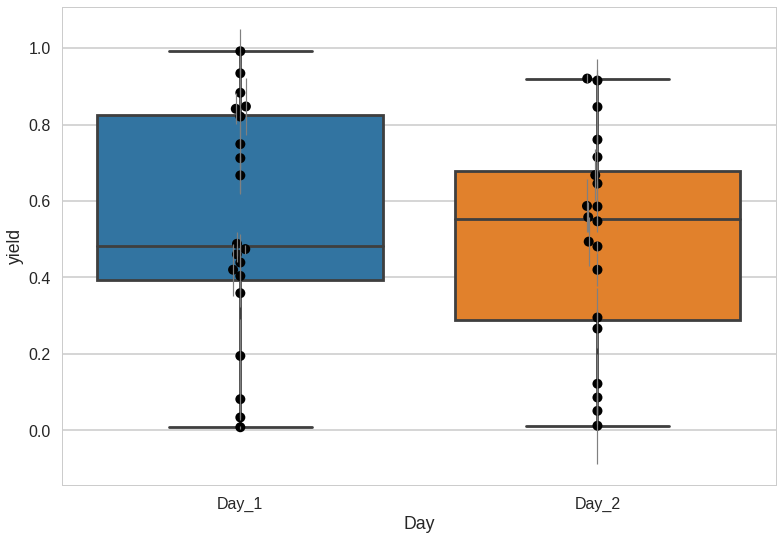

In [61]:
day = day_finder('Results')
Results_m = pd.DataFrame(columns=['yield', 'std', 'Day'])
for i in range(1,day):
    Results_i = pd.DataFrame(columns=['yield', 'std', 'Day'])
    Results_i['yield'] = pd.read_csv(f'Day_{i}/Results_{i}.csv')['yield'].iloc[0:days_range[i-1]]
    try:
        Results_i['std'] = pd.read_csv(f'Day_{i}/Results_{i}.csv')['yield_std'].iloc[0:days_range[i-1]]
    except:
        Results_i['std'] = 0
    Results_i['Day'] = f'Day_{i}'
    Results_m = pd.concat([Results_m, Results_i])

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(1, 1)

ax = sns.boxplot(x='Day', y='yield', data=Results_m, fliersize=0)
ax = sns.swarmplot(x='Day', y='yield', data=Results_m, color='k', size=10)

if display_std:
    # Find the x,y coordinates for each point
    x_coords = []
    y_coords = []
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            x_coords.append(x)
            y_coords.append(y)

    errors = Results_m['std']
    ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ',color="grey", zorder=3, linewidth=1.2)
ax